# Data preparation

In [1]:
import pandas as pd
df=pd.read_csv('./plant_growth_data.csv')
df

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0
...,...,...,...,...,...,...,...
188,sandy,5.652000,daily,none,28.000000,70.200000,0
189,clay,7.528000,weekly,chemical,30.500000,60.100000,1
190,loam,4.934000,bi-weekly,none,24.500000,61.700000,0
191,sandy,8.273000,daily,organic,27.900000,69.500000,1


### Missing values

In [2]:
print(df.isnull().sum())

Soil_Type           0
Sunlight_Hours      0
Water_Frequency     0
Fertilizer_Type     0
Temperature         0
Humidity            0
Growth_Milestone    0
dtype: int64


There is no missing values

### Feature disctetizing

In [3]:
df.nunique()

Soil_Type             3
Sunlight_Hours      190
Water_Frequency       3
Fertilizer_Type       3
Temperature         189
Humidity            191
Growth_Milestone      2
dtype: int64

Columns to discretize: 
* Sunlight_Hours
* Humidity
* Temperature

In [4]:
df[['Sunlight_Hours','Humidity','Temperature']].describe()

,Sunlight_Hours,Humidity,Temperature
count,193.000000,193.000000,193.000000
mean,6.826484,58.098927,25.076087
std,1.599509,12.631799,5.354170
min,4.033133,30.567682,15.200000
25%,5.477000,49.300000,20.637095
50%,6.833290,59.182806,25.912336
75%,8.241144,69.100000,29.757938
max,9.913903,79.648240,34.810103


In [5]:
df['Sunlight_Hours']=pd.cut(df['Sunlight_Hours'],bins=4,labels=['dark','moderate','sunny','bright'])
df['Humidity']=pd.cut(df['Humidity'],bins=5,labels=['low_moist','avg_moist','moist','high_moist','humid'])
df['Temperature']=pd.cut(df['Temperature'],bins=3,labels=['cold','norm','hot'])

In [6]:
df.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,dark,bi-weekly,chemical,hot,high_moist,0
1,sandy,dark,weekly,organic,hot,moist,1
2,loam,bright,bi-weekly,none,norm,avg_moist,0
3,loam,sunny,bi-weekly,none,cold,avg_moist,0
4,sandy,sunny,bi-weekly,organic,cold,high_moist,0


# Model building 

In [7]:
from pgmpy.models import DiscreteBayesianNetwork

model = DiscreteBayesianNetwork([
    ("Soil_Type", "Growth_Milestone"),
    ("Sunlight_Hours", "Growth_Milestone"),
    ("Water_Frequency", "Growth_Milestone"),
    ("Fertilizer_Type", "Growth_Milestone"),
    ("Temperature", "Growth_Milestone"),
    ("Humidity", "Growth_Milestone"),
])


In [8]:
from pgmpy.estimators import MaximumLikelihoodEstimator
model.fit(df, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Soil_Type': 'C', 'Sunlight_Hours': 'O', 'Water_Frequency': 'C', 'Fertilizer_Type': 'C', 'Temperature': 'O', 'Humidity': 'O', 'Growth_Milestone': 'N'}


In [10]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
query_result = inference.query(
    variables=["Growth_Milestone"],
    evidence={
        "Soil_Type": 'loam',
        "Water_Frequency": 'weekly',
        "Fertilizer_Type": 'chemical'
    }
)
print(query_result)


+---------------------+-------------------------+
| Growth_Milestone    |   phi(Growth_Milestone) |
+=====================+=========================+
| Growth_Milestone(0) |                  0.5217 |
+---------------------+-------------------------+
| Growth_Milestone(1) |                  0.4783 |
+---------------------+-------------------------+


In [11]:
print("Nodes:", list(model.nodes()))
print("Edges:", list(model.edges()))

Nodes: ['Soil_Type', 'Growth_Milestone', 'Sunlight_Hours', 'Water_Frequency', 'Fertilizer_Type', 'Temperature', 'Humidity']
Edges: [('Soil_Type', 'Growth_Milestone'), ('Sunlight_Hours', 'Growth_Milestone'), ('Water_Frequency', 'Growth_Milestone'), ('Fertilizer_Type', 'Growth_Milestone'), ('Temperature', 'Growth_Milestone'), ('Humidity', 'Growth_Milestone')]


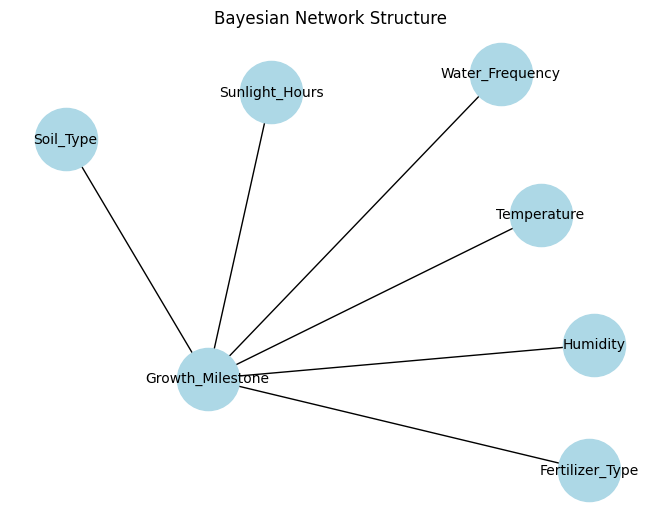

In [12]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color='lightblue',
    font_size=10,
    arrows=False
)
plt.title("Bayesian Network Structure")
plt.show()
